Do not delete this cell. It defines custom LaTeX commands.
$$
\newcommand{\xb}{\boldsymbol{x}}
\newcommand{\wb}{\boldsymbol{w}}
\newcommand{\pb}{\boldsymbol{p}}
\newcommand{\1}{\mathbb{1}}
$$

# Convolutions and Convolutional Neural Networks

Here you'll experiment with convolutions, on CPUs and GPUs, and with convolutional neural networks.

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import skimage.data
import skimage.color
import scipy.misc
import scipy.signal
import time

import torch
from torch.autograd import Variable
import torch.nn.functional as F

from matplotlib import rcParams
rcParams['axes.grid'] = False

import warnings
warnings.filterwarnings("ignore")

## Convolutions with SciPy

Let's start by loading a simple image of coffee using scikit-image, converting it to grayscale, and viewing it.

**You will likely get an error when you run the following line of code. This issue has to do with Google's Colaboratory environment. To fix it, just restart the runtime (`Runtime -> Restart Runtime`) and then run all of the code above again (`Runtime -> Run Before`).**

In [0]:
image = skimage.color.rgb2gray(skimage.data.coffee()).astype(np.float32)

**In the following cell, write code to print this image's `dtype`, `shape`, and minimum and maximum values.**

In [3]:
print(image.dtype)
print(image.shape)
print(np.min(image))
print(np.max(image))

float32
(400, 600)
0.0002827451
1.0


Let's view the image:

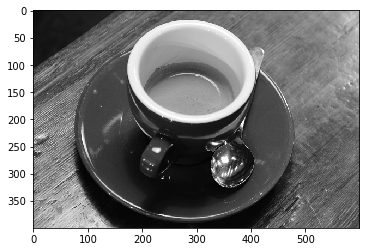

In [4]:
plt.imshow(image)
plt.axis('image')
plt.set_cmap('gray')

Now let's create a 15 x 15 averaging filter:

In [0]:
kernel_shape = [15, 15]
kernel = np.ones(kernel_shape, dtype=np.float32) / np.prod(kernel_shape)

**In the following Markdown cell, answer: Why are we dividing by the product of `kernel_shape`'s elements here?**

If the kernel was just all ones, then essentially we might multiply the response at each pixel by 15x15 times. But when divide it by the `np.prod(kernel_shape)`, which equal to `15*15` that is the total number of cells in the kernel, we are essentially ensuring that the final averaged sum less than or equals one, which is essentially the average of all the 15x15 pixels.

In [6]:
image_smoothed = scipy.signal.convolve2d(image, kernel, mode='same')
kernel.shape

(15, 15)

**Copy the previous line of code to the cell below and use IPython's `%timeit` magic to see how long this convolution takes.**

In [7]:
%timeit image_smoothed = scipy.signal.convolve2d(image, kernel, mode='same')

10 loops, best of 3: 164 ms per loop


**In the following Markdown cell, answer: Approximately how many milliseconds does it take for this 2-D convolution to complete?**

It takes `146 milliseconds`.


In [8]:
test_image_smoothed = scipy.signal.convolve2d(image, kernel, mode='valid')
print(test_image_smoothed.shape)

(386, 586)


**In the following Markdown cell, answer: We specified `mode='same'` so that the output image has the same size as the input image. If we instead retained only *valid* outputs – those computed using only values within `image` and `kernel` – what would the shape of the output image be?**

If we retained only `valid` outputs, then we will not be padding the image matrix with zeros to maintain the image size. This implies if we use a stride of 1, then the image size gets tonned down by 14 (Height-1) rows and 14 (width-1) columns. 

This implies the new shape will be: (386 x 586), which was (400, 600) initially. (see above)


**In the following Markdown cell, answer: Expanding on the previous question, suppose you convolve an image of shape `[HEIGHT, WIDTH]` with a kernel of smaller shape `[K_HEIGHT, K_WIDTH]`, where `K_HEIGHT` and `K_WIDTH` are odd. Then what is the shape of the output of the convolution if only *valid* outputs are retained?**

The shape of the output if only valid inputs are used and the stride is only one. Is: `[HEIGHT - (K_HEIGHT - 1), WIDTH - (K_WIDTH - 1)]`.

Let's visualize the output of this convolution.

(-0.5, 599.5, 399.5, -0.5)

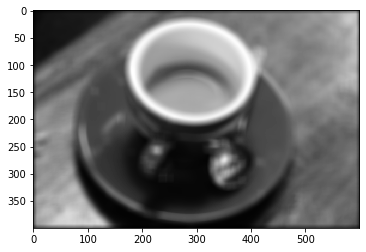

In [9]:
plt.imshow(image_smoothed)
plt.axis('image')

**In the following Markdown cell, answer: Why is there an artificial dark border surrounding this output image (which is not present in the original image above)?**

This is the result of using `mode='same'`. Here the original image is effectively padded with 0s so that a 'valid' convolution yields an output that has the same shape as the input image. These 0s are darker than the actual image, so when we include them in our averages, we see this artificial border.

## Convolutions with PyTorch (CPU only)

In [0]:
image_ = Variable(torch.from_numpy(image))
kernel_ = Variable(torch.from_numpy(kernel))

**In the following Markdown cell, answer: Look up the documentation for `torch.nn.functional.conv2d`. What shape does it expect for `input`, and what shape does it expect for `weight`? (Note that in our usage, the argument `groups` is 1.)**

The shapes it expects for the following:

input – tensor of shape `(minibatch_size × number_of_in_channels × image_Height  × image_Width)`

weight – filters of shape `(number_of_out_channels × number_of_in_channels × kernel_Height × kernel_Width)`

Note: This assumes groups = 1

**In the following cell, write code to reshape `image_` and `kernel_` so that they can be passed to `torch.nn.functional.conv2d`.**

In [11]:
image_ = image_.view(1, 1, image_.shape[0], image_.shape[1])
kernel_ = kernel_.view(1, 1, kernel_.shape[0], kernel_.shape[1])
print(image_.shape)
print(kernel_.shape)

torch.Size([1, 1, 400, 600])
torch.Size([1, 1, 15, 15])


Now let's define appropriate padding (so that our output image again remains the same size at the input image) and use PyTorch's `conv2d` to perform the convolution.

In [0]:
padding = (kernel_shape[0] // 2, kernel_shape[1] // 2)
image_smoothed_ = F.conv2d(image_, kernel_, padding=padding)

**Copy the previous cell's code to the cell below and use IPython's `%timeit` magic to see how long this convolution takes in PyTorch.**

In [13]:
%timeit image_smoothed_ = F.conv2d(image_, kernel_, padding=padding)

10 loops, best of 3: 85.6 ms per loop


**In the following Markdown cell, answer: Approximately how many milliseconds does it take for this 2-D convolution to complete?**

It takes `17.4 milliseconds`.

**In the following Markdown cell, answer: How much faster is PyTorch's implementation in comparison to SciPy's? (To answer this, just compute the ratio $T_\text{SciPy}$ / $T_\text{PyTorch}$.)**

$T_\text{SciPy}$ / $T_\text{PyTorch} =  146 / 17.4$  

= >`PyTorch` is 8.39 times faster than `SciPy`


**In the following Markdown cell, answer: Can you guess why PyTorch is faster here? (It's fine if you aren't sure; if so, just leave it blank.)**

I guess, as PyTorch is essentially a port of Torch (a scientific computing framework) for Lua, which was built with efficeincy and speed in mind, it is faster than SciPy. While SciPy on the contrary has many Pythonic parts to it, though the core is in C, hence making it slower.

Again let's visualize the output to make sure it's what we expect.

(-0.5, 599.5, 399.5, -0.5)

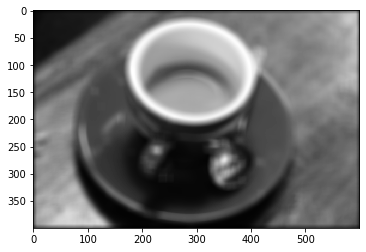

In [14]:
plt.imshow(image_smoothed_.numpy().squeeze())
plt.axis('image')

## Convolutions with PyTorch (GPU)

Now let's move on to using CUDA in PyTorch, to leverage GPUs. (If you haven't heard of CUDA, take a quick look at https://en.wikipedia.org/wiki/CUDA.)

In [0]:
assert torch.cuda.is_available()

**If the above `assert` fails, hit `Edit -> Notebook Settings` and make sure GPU acceleration is enabled.**

In [0]:
image_ = image_.cuda()
kernel_ = kernel_.cuda()

In [0]:
image_smoothed_ = F.conv2d(image_, kernel_, padding=padding)

**Copy the above code to the cell below and use IPython's `%timeit` magic to see how long this convolution takes in PyTorch using our GPU.**

In [18]:
%timeit F.conv2d(image_, kernel_, padding=padding)

10000 loops, best of 3: 1.2 ms per loop


**In the following Markdown cell, answer: Approximately how many milliseconds does it take for this 2-D convolution to complete?**

It takes `1.79 milliseconds`.

**In the following Markdown cell, answer: How much faster is PyTorch's GPU implementation in comparison to SciPy's CPU implementation? And how much faster is PyTorch's GPU implementation than PyTorch's CPU implementation? (Answer these as done above, as $T_\text{PyTorch GPU}$ / $T_\text{SciPy}$ and $T_\text{PyTorch GPU}$ / $T_\text{PyTorch CPU}$.)**

$T_\text{SciPy}$ / $T_\text{PyTorch GPU}$ = $146/1.79$ => 81.56

This implies **Pytorch GPU** is 81.56 times faster than **SciPy**


$T_\text{PyTorch CPU}$ / $T_\text{PyTorch GPU}$ = $17.4/1.79$ = 9.72

This implies **Pytorch GPU** is 9.72 times faster than the **PyTorch CPU** implementation

Now let's go on to convolve an RGB image (height x width x 3) with a kernel that's 15 x 15 x 3.

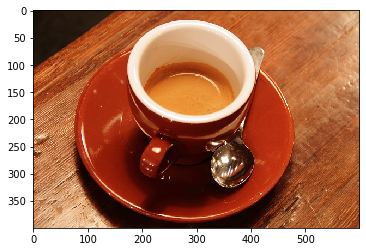

In [19]:
image = skimage.data.coffee().astype(np.float32)
image /= image.max()
plt.imshow(image)

**In the following cell, write code to print this image's `dtype`, `shape`, and minimum and maximum values.**

In [20]:
print(image.dtype)
print(image.shape)
print(np.min(image))
print(np.max(image))

float32
(400, 600, 3)
0.0
1.0


In [0]:
kernel_shape = [15, 15, 3]
kernel = np.ones(kernel_shape, dtype=np.float32) / np.prod(kernel_shape)

In [22]:
image_ = Variable(torch.from_numpy(image).cuda())
kernel_ = Variable(torch.from_numpy(kernel).cuda())
print(image_.shape)
print(kernel_.shape)

torch.Size([400, 600, 3])
torch.Size([15, 15, 3])


**In the following cell, write code to permute and reshape axes so that `image_` and `kernel_` have the shapes expected by `torch.nn.functional.conv2d`. (You can use `permute` and `unsqueeze` here.)**

In [23]:
image_ = torch.unsqueeze(image_.permute(2, 0, 1), 0)
kernel_ = torch.unsqueeze(kernel_.permute(2, 0, 1), 0)
print(image_.shape)
print(kernel_.shape)

torch.Size([1, 3, 400, 600])
torch.Size([1, 3, 15, 15])


After the `permute`, we need to make our Variables contiguous. (`permute` changes the order in which we view memory, but avoids rearranging the order explicitly. Thus we need to explicitly reorder the memory so that future manipulations can operate as expected.)

In [0]:
image_ = image_.contiguous()
kernel_ = kernel_.contiguous()

**In the following cell, write code to print the shape of `image_` and `kernel_`, and confirm they're what you expect.**

In [25]:
print(image_.shape)
print(kernel_.shape)

torch.Size([1, 3, 400, 600])
torch.Size([1, 3, 15, 15])


In [0]:
output_ = F.conv2d(image_, kernel_, padding=padding)

**In the following cell, write code to print the `type` and `shape` of `output_`.**

In [27]:
print(output_.type)
print(output_.shape)

<built-in method type of Tensor object at 0x7ff4822ac438>
torch.Size([1, 1, 400, 600])


**In the following Markdown cell, answer: Why does the output have 1 output channel instead of 3?**

Each output pixel is the result of an average across *all three channels* of a 15 x 15 spatial window. Here the window moves only over spatial dimensions, not channels.

Finally, let's visualize the result.

(-0.5, 599.5, 399.5, -0.5)

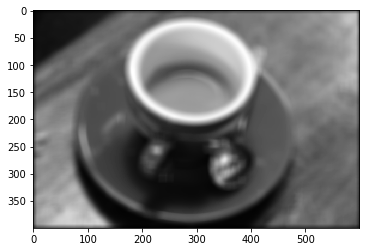

In [28]:
plt.imshow(output_.detach().cpu().numpy().squeeze())
plt.axis('image')

## MNIST Classification with Extremely Simple CNNs

In [0]:
import torchvision

from pathlib import Path
HOME = Path.home()
MNIST_PATH = HOME / 'data' / 'mnist'

NUM_CLASSES = 10
CHANNELS = 1
HEIGHT = 28
WIDTH = 28

In [30]:
# We're going to load the official train set and never touch
# the true test set in these experiments, which consists of 10,000
# separate examples. We'll instead split our training set into
# a set for training and a set for validation.
official_mnist_train = torchvision.datasets.MNIST(str(MNIST_PATH), train=True, download=True)
official_train_images = official_mnist_train.train_data.numpy().astype(np.float32)
official_train_labels = official_mnist_train.train_labels.numpy().astype(np.int)


Extracting /root/data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to /root/data/mnist/MNIST/raw



Extracting /root/data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to /root/data/mnist/MNIST/raw



Extracting /root/data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/data/mnist/MNIST/raw



Extracting /root/data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/data/mnist/MNIST/raw
Processing...
Done!


In [31]:
print(official_train_images.shape)
print(official_train_labels.shape)

(60000, 28, 28)
(60000,)


Let's view a few examples:

[5 0 4 1 9 2 1 3 1 4]


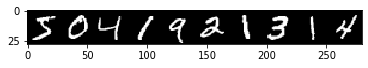

In [32]:
example_images = np.concatenate(official_train_images[:10], axis=1)
example_labels = official_train_labels[:10]
print(example_labels)
plt.imshow(example_images)

Here we'll split our training set into 55000 for training and the rest for validation.

In [0]:
train_images, val_images = np.split(official_train_images, [55000])
train_labels, val_labels = np.split(official_train_labels, [55000])

In [34]:
print(train_images.shape, train_labels.shape)
print(val_images.shape, val_labels.shape)

(55000, 28, 28) (55000,)
(5000, 28, 28) (5000,)


And we'll normalize our data in one of the simplest ways possible: centering and scaling on an image-by-image basis.

In [0]:
def normalize_stats_image_by_image(images):
  mean = images.mean(axis=(1,2), keepdims=True)
  stdev = images.std(axis=(1,2), keepdims=True)
  return (images - mean) / stdev

In [0]:
train_images = normalize_stats_image_by_image(train_images)
val_images = normalize_stats_image_by_image(val_images)

In [37]:
print(train_images[:3].mean(axis=(1, 2)))
print(train_images[:3].std(axis=(1, 2)))
print(val_images[:3].mean(axis=(1, 2)))
print(val_images[:3].std(axis=(1, 2)))

[ 0.0000000e+00 -1.2164214e-08  0.0000000e+00]
[1. 1. 1.]
[-3.8925482e-08 -4.8656852e-09 -4.3791168e-08]
[1. 1. 1.]


As before, we'll define a function to return a batch of examples. However this time we'll assume we have a GPU available.

In [0]:
def batch(batch_size, training=True):
  """Create a batch of examples.
  
  This creates a batch of input images and a batch of corresponding
  ground-truth labels. We assume CUDA is available (with a GPU).
  
  Args:
    batch_size: An integer.
    training: A boolean. If True, grab examples from the training
      set; otherwise, grab them from the validation set.
  
  Returns:
    A tuple,
    input_batch: A Variable of floats with shape
      [batch_size, 1, height, width]
    label_batch: A Variable of ints with shape
      [batch_size].
  """
  if training:
    random_ind = np.random.choice(train_images.shape[0], size=batch_size, replace=False)
    input_batch = train_images[random_ind]
    label_batch = train_labels[random_ind]
  else:
    input_batch = val_images[:batch_size]
    label_batch = val_labels[:batch_size]
  
  input_batch = input_batch[:, np.newaxis, :, :]
  
  input_batch = torch.tensor(input_batch, requires_grad=False, device='cuda')
  label_batch = torch.tensor(label_batch, requires_grad=False, device='cuda')
  
  return input_batch, label_batch

**Below, you will define a `SimpleCNN` with some significant restrictions on the model class: (1) Input to conv_final needs to be a single pixel (see comments where it is defined). (2) Only Convolutions and ReLUs can be used. In other words, do not use max pooling, do not use dropout, etc. (3) For full credit, achieve better than 2% error.**

**The purpose of this is to (1) gain competency with the basic settings for convolutions and (2) develop a practical sense for how important these basic settings are.**

Hint 1: You can use the `stride` argument in the convolutions.

Hint 2: This can easily be achieved in well under 5000 iterations using the same optimizer settings as below (Adam with a learning rate of 0.001).

In [0]:
class SimpleCNN(torch.nn.Module):
  """A simple convolutional network.
  
  Map from inputs with shape [batch_size, 1, height, width] to
  outputs with shape [batch_size, 1].
  """
  
  def __init__(self):
    super().__init__()
    self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=7, padding=7//2)
    # TODO
    # (You may also need to modify conv_final.)
    self.conv2 = torch.nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=3//2)
    self.conv3 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=3//2)
    self.conv4 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=3//2)
    self.conv5 = torch.nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=3//2)
    
    # Here the input to conv_final should be a single pixel, as can be obtained
    # by pooling spatially over all pixels. The goal of conv_final is to map
    # from some number of channels to 10, one for each possible class.
    self.conv_final = torch.nn.Conv2d(128, 10, kernel_size=1)
    
  def forward(self, x):
    x = F.relu(self.conv1(x))
    # TODO
    x = F.relu(self.conv2(x))
    x = F.relu(self.conv3(x))
    x = F.relu(self.conv4(x))
    x = F.relu(self.conv5(x))
    
    spatial_shape = x.shape[2:]
    # Average each channel over spatial dimensions.
    x = F.avg_pool2d(x, kernel_size=spatial_shape)
    x = self.conv_final(x).view(-1, 10)
    return x
    

And instantiate our model... notice again that we assume CUDA is available, and that moving all parameters to the GPU is as simple as running `model.cuda()`.

In [47]:
model = SimpleCNN()
model.cuda()

SimpleCNN(
  (conv1): Conv2d(1, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv5): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_final): Conv2d(128, 10, kernel_size=(1, 1), stride=(1, 1))
)

In [0]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [0]:
def train_step(batch_size=128):
  
  model.train()

  input_batch, label_batch = batch(batch_size, training=True)
  output_batch = model(input_batch)
  
  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()

  optimizer.zero_grad()
  loss.backward()
  
  optimizer.step()
  
  return loss.item(), error_rate.item()

In [0]:
def val():
  
  model.eval()
  input_batch, label_batch = batch(val_images.shape[0], training=False)
  output_batch = model(input_batch)

  loss = F.cross_entropy(output_batch, label_batch)
  _, pred_batch = torch.max(output_batch, dim=1)
  error_rate = 1.0 - (pred_batch == label_batch).float().mean()
  
  return loss.item(), error_rate.item()

Finally, let's train, and also plot loss and error rate as a function of iteration.

Step     0: Obtained a best validation error of 0.894.
Step    50: Obtained a best validation error of 0.498.
Step   100: Obtained a best validation error of 0.216.
Step   150: Obtained a best validation error of 0.135.
Step   200: Obtained a best validation error of 0.108.
Step   250: Obtained a best validation error of 0.094.
Step   300: Obtained a best validation error of 0.078.
Step   350: Obtained a best validation error of 0.061.
Step   450: Obtained a best validation error of 0.054.
Step   600: Obtained a best validation error of 0.044.
Step   750: Obtained a best validation error of 0.039.
Step   800: Obtained a best validation error of 0.037.
Step   850: Obtained a best validation error of 0.035.
Step   900: Obtained a best validation error of 0.032.
Step   950: Obtained a best validation error of 0.029.
Step  1000: Obtained a best validation error of 0.029.
Step  1100: Obtained a best validation error of 0.028.
Step  1350: Obtained a best validation error of 0.026.
Step  1400

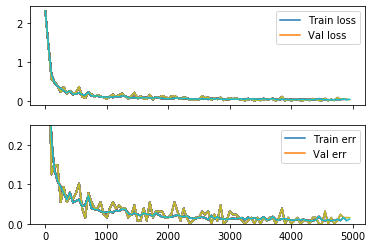

In [51]:
# Let's make sure we always start from scratch (that is,
# without starting from parameters from a previous run).
for module in model.children():
  module.reset_parameters()

info = []
fig, ax = plt.subplots(2, 1, sharex=True)
num_steps = 5000
num_steps_per_val = 50
best_val_err = 1.0
for step in range(num_steps):
  train_loss, train_err = train_step()
  if step % num_steps_per_val == 0:
    val_loss, val_err = val()
    if val_err < best_val_err:
      best_val_err = val_err
      print('Step {:5d}: Obtained a best validation error of {:.3f}.'.format(step, best_val_err))
    info.append([step, train_loss, val_loss, train_err, val_err])
    x, y11, y12, y21, y22 = zip(*info)
    ax[0].plot(x, y11, x, y12)
    ax[0].legend(['Train loss', 'Val loss'])
    ax[1].plot(x, y21, x, y22)
    ax[1].legend(['Train err', 'Val err'])
    ax[1].set_ylim([0.0, 0.25])

I was able to achieve a best validation error of less than 2% which is **1.9% at 900 iterations**.

Plus, in the end after **5000 iterations (around 4950 iterations)**, my model achieved a best validation error as low as **0.7%**.

For more details see the above graph.